In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import torch
import matplotlib.pyplot as plt

### Load Data

In [2]:
data_train = pd.read_csv('Google_Stock_Price_Train.csv.xls', thousands=',')
data_train.shape

(1258, 6)

In [3]:
data_test = pd.read_csv('Google_Stock_Price_Test.csv.xls',thousands=',')
data_test

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,1657300
1,1/4/2017,788.36,791.34,783.16,786.90,1073000
2,1/5/2017,786.08,794.48,785.02,794.02,1335200
3,1/6/2017,795.26,807.90,792.20,806.15,1640200
4,1/9/2017,806.40,809.97,802.83,806.65,1272400
5,1/10/2017,807.86,809.13,803.51,804.79,1176800
6,1/11/2017,805.00,808.15,801.37,807.91,1065900
7,1/12/2017,807.14,807.39,799.17,806.36,1353100
8,1/13/2017,807.48,811.22,806.69,807.88,1099200
9,1/17/2017,807.08,807.14,800.37,804.61,1362100


In [4]:
data = pd.concat([data_train,data_test], axis=0 )
data

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,7380500
1,1/4/2012,331.27,333.87,329.08,666.45,5749400
2,1/5/2012,329.83,330.75,326.89,657.21,6590300
3,1/6/2012,328.34,328.77,323.68,648.24,5405900
4,1/9/2012,322.04,322.29,309.46,620.76,11688800
...,...,...,...,...,...,...
15,1/25/2017,829.62,835.77,825.06,835.67,1494500
16,1/26/2017,837.81,838.00,827.01,832.15,2973900
17,1/27/2017,834.71,841.95,820.44,823.31,2965800
18,1/30/2017,814.66,815.84,799.80,802.32,3246600


In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
data = data.iloc[:,1:]
data

,Open,High,Low,Close,Volume
0,325.25,332.83,324.97,663.59,7380500
1,331.27,333.87,329.08,666.45,5749400
2,329.83,330.75,326.89,657.21,6590300
3,328.34,328.77,323.68,648.24,5405900
4,322.04,322.29,309.46,620.76,11688800
...,...,...,...,...,...
15,829.62,835.77,825.06,835.67,1494500
16,837.81,838.00,827.01,832.15,2973900
17,834.71,841.95,820.44,823.31,2965800
18,814.66,815.84,799.80,802.32,3246600


In [6]:
data_scaled = scaler.fit_transform(data)
data_scaled.shape

(1278, 5)

In [7]:
def split_data(stock, lookback): 
    data = []

    for i in range(len(stock) - lookback): 
        data.append(stock[i: i + lookback])
    
    data = np.array(data);
    val_set_size = int(np.round(0.2*data_train.shape[0]));
    train_set_size = data_train.shape[0] - (val_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_val = data[train_set_size:,:-1]
    y_val = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_val, y_val]

In [8]:
lookback = 30
x_train, y_train, x_val, y_val = split_data(data_scaled, lookback)

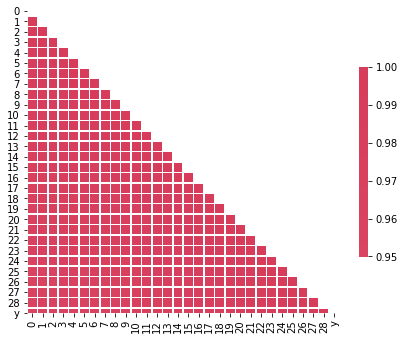

In [9]:
#create training dataframe to check correlation
df_y = pd.DataFrame(y_train[:,0],columns = ['y'])
df_x = pd.DataFrame(x_train[:,:,0])
df = pd.concat([df_x, df_y], axis=1)

corr_matrix_1 = df.corr()
f, ax = plt.subplots(figsize=(7, 7))
cmap = sns.diverging_palette(240, 5, as_cmap=True)
mask = np.triu(np.ones_like(corr_matrix_1, dtype=np.bool))
sns.heatmap(corr_matrix_1, mask= mask, cmap=cmap, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

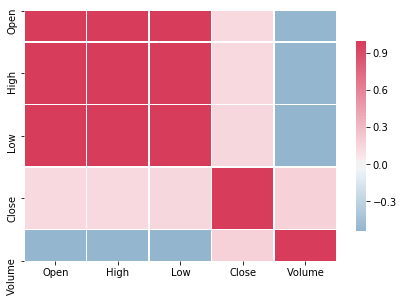

In [10]:
corr_matrix = data.corr()
f, ax = plt.subplots(figsize=(7, 7))
cmap = sns.diverging_palette(240, 5, as_cmap=True)
sns.heatmap(corr_matrix, cmap=cmap, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [11]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_val = torch.from_numpy(x_val).type(torch.Tensor)

y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_val_lstm = torch.from_numpy(y_val).type(torch.Tensor)

y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_val_gru = torch.from_numpy(y_val).type(torch.Tensor)

y_train_rnn = torch.from_numpy(y_train).type(torch.Tensor)
y_val_rnn = torch.from_numpy(y_val).type(torch.Tensor)


#### Test data preprocessing

In [12]:
lookback = 30

def split_test(stock, lookback): 
    data = []

    for i in range(len(stock) - lookback): 
        data.append(stock[i: i + lookback])
    
    data = np.array(data);
    
    x_test = data[1228:,:-1,:]
    y_test = data[1228:,-1,:]
    
    return [x_test, y_test]

x_test, y_test = split_test(data_scaled, lookback)


In [13]:
x_test = torch.from_numpy(x_test).type(torch.Tensor)

y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)
y_test_rnn = torch.from_numpy(y_test).type(torch.Tensor)

x_test.shape

torch.Size([20, 29, 5])

### LSTM

In [14]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [15]:
input_dim = 5
hidden_dim = 128
num_layers = 1
output_dim = 5
num_epochs = 200

In [16]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [17]:
import time
start_time = time.time()

hist = np.zeros(num_epochs)
lstm = []
for t in range(num_epochs):
    y_train_pred_lstm = model(x_train)
    loss = criterion(y_train_pred_lstm, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
lstm_training_time = time.time()-start_time
print("Training time: {}".format(lstm_training_time))

Epoch  0 MSE:  0.36247849464416504
Epoch  1 MSE:  0.2060684710741043
Epoch  2 MSE:  0.40374526381492615
Epoch  3 MSE:  0.12260264158248901
Epoch  4 MSE:  0.15468867123126984
Epoch  5 MSE:  0.16051511466503143
Epoch  6 MSE:  0.14345765113830566
Epoch  7 MSE:  0.12448606640100479
Epoch  8 MSE:  0.10807452350854874
Epoch  9 MSE:  0.0814993679523468
Epoch  10 MSE:  0.05053434520959854
Epoch  11 MSE:  0.036433182656764984
Epoch  12 MSE:  0.04006687551736832
Epoch  13 MSE:  0.03558450564742088
Epoch  14 MSE:  0.029210258275270462
Epoch  15 MSE:  0.02978184074163437
Epoch  16 MSE:  0.02876899391412735
Epoch  17 MSE:  0.023248916491866112
Epoch  18 MSE:  0.01780499890446663
Epoch  19 MSE:  0.014146805740892887
Epoch  20 MSE:  0.013079113326966763
Epoch  21 MSE:  0.013713249936699867
Epoch  22 MSE:  0.014240074902772903
Epoch  23 MSE:  0.013377861119806767
Epoch  24 MSE:  0.011449893936514854
Epoch  25 MSE:  0.009784775786101818
Epoch  26 MSE:  0.009158281609416008
Epoch  27 MSE:  0.00940027646

In [18]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred_lstm.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

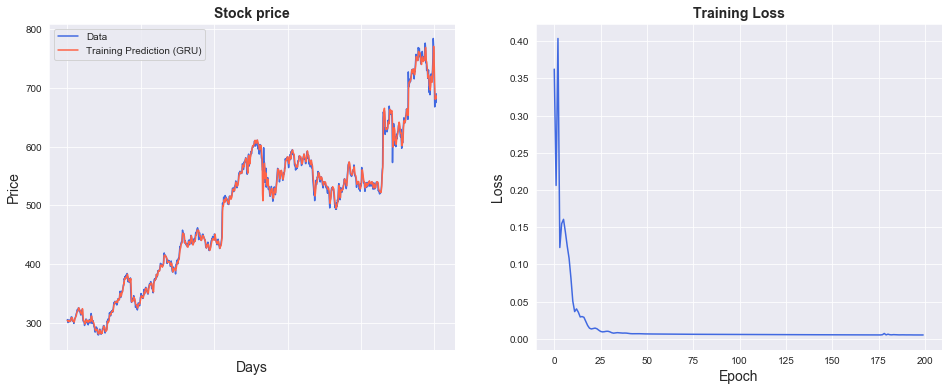

In [19]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Price", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [20]:
# make predictions with validation set
y_val_pred_lstm = model(x_val)
y_val_pred_lstm

#invert predictions
y_train_pred_lstm = scaler.inverse_transform(y_train_pred_lstm.detach().numpy())
y_train_lstm = scaler.inverse_transform(y_train_lstm.detach().numpy())

y_val_pred_lstm = scaler.inverse_transform(y_val_pred_lstm.detach().numpy())
y_val_lstm = scaler.inverse_transform(y_val_lstm.detach().numpy())

In [21]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
import math

lstm_train_error_list = [] 
for i in range(5):
    train_error_lstm  = math.sqrt(mean_squared_error(y_train_lstm[:,i], y_train_pred_lstm[:,i]))
    lstm_train_error_list.append(train_error_lstm)
    
lstm_val_error_list = []    
for i in range(5):
    val_error_lstm  = math.sqrt(mean_squared_error(y_val_lstm[:,i], y_val_pred_lstm[:,i]))
    lstm_val_error_list.append(val_error_lstm)

In [22]:
print(lstm_train_error_list)
print(lstm_val_error_list)

[7.866032656751438, 8.682430407341041, 8.711877664370915, 23.333625283004274, 1680218.863305611]
[7.8516990232222685, 7.542202784694865, 12.077694824769893, 11.206556403869365, 1002798.7939043405]


In [23]:
# make predictions with test set
y_test_pred_lstm = model(x_test)

# invert predictions
y_test_pred_lstm = scaler.inverse_transform(y_test_pred_lstm.detach().numpy())
y_test_lstm = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
lstm_test_error_list = []
for i in range(5):
    test_error_lstm  = math.sqrt(mean_squared_error(y_test_lstm[:,i], y_test_pred_lstm[:,i]))
    lstm_test_error_list.append(test_error_lstm)
    
print(lstm_test_error_list)

[11.465720792688893, 9.954154400014897, 18.45028191741338, 17.747000427393974, 972189.9223834816]


In [24]:
Error_test_pct_list_lstm = []

for i in range(5):
    Error_test_pct_lstm = abs(y_test_lstm[:,i] - y_test_pred_lstm[:,i])
    Error_test_pct_lstm = np.mean(Error_test_pct_lstm)
    Error_test_pct_lstm = Error_test_pct_lstm/(y_test_pred_lstm[:,i].mean())
    Error_test_pct_list_lstm.append(Error_test_pct_lstm)

print('LSTM test - (MAPE):', Error_test_pct_list_lstm)     

LSTM test - (MAPE): [0.013048865, 0.0101772845, 0.022131866, 0.020492785, 0.38172984]


### GRU

In [25]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [26]:
input_dim = 5
hidden_dim = 128
num_layers = 1
output_dim = 5
num_epochs = 200

In [27]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [28]:
start_time = time.time()

hist = np.zeros(num_epochs)

for t in range(num_epochs):
    y_train_pred_gru = model(x_train)

    loss = criterion(y_train_pred_gru, y_train_gru)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
gru_training_time = time.time()-start_time    
print("GRU_Training time: {}".format(gru_training_time))

Epoch  0 MSE:  0.35280290246009827
Epoch  1 MSE:  0.14906539022922516
Epoch  2 MSE:  0.12298154085874557
Epoch  3 MSE:  0.04683379456400871
Epoch  4 MSE:  0.05473282188177109
Epoch  5 MSE:  0.05047309398651123
Epoch  6 MSE:  0.03287062048912048
Epoch  7 MSE:  0.018830273300409317
Epoch  8 MSE:  0.01903967186808586
Epoch  9 MSE:  0.016982685774564743
Epoch  10 MSE:  0.018106229603290558
Epoch  11 MSE:  0.020032819360494614
Epoch  12 MSE:  0.014545317739248276
Epoch  13 MSE:  0.009514371864497662
Epoch  14 MSE:  0.008319087326526642
Epoch  15 MSE:  0.00888535100966692
Epoch  16 MSE:  0.009666673839092255
Epoch  17 MSE:  0.010390038602054119
Epoch  18 MSE:  0.010745687410235405
Epoch  19 MSE:  0.010272257030010223
Epoch  20 MSE:  0.008892429061233997
Epoch  21 MSE:  0.0071736108511686325
Epoch  22 MSE:  0.005994217935949564
Epoch  23 MSE:  0.005851130001246929
Epoch  24 MSE:  0.006432417780160904
Epoch  25 MSE:  0.00695041473954916
Epoch  26 MSE:  0.0068992143496870995
Epoch  27 MSE:  0.0

In [29]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred_gru.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_gru.detach().numpy()))

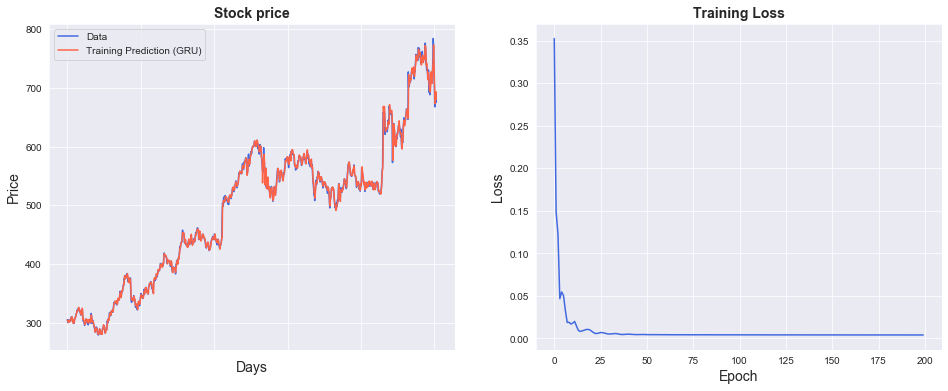

In [30]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Price", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [31]:
# make predictions
y_val_pred_gru = model(x_val)

In [32]:
# invert predictions

y_train_pred_gru = scaler.inverse_transform(y_train_pred_gru.detach().numpy())
y_train_gru = scaler.inverse_transform(y_train_gru.detach().numpy())

y_val_pred_gru = scaler.inverse_transform(y_val_pred_gru.detach().numpy())
y_val_gru = scaler.inverse_transform(y_val_gru.detach().numpy())


In [33]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
import math

gru_train_error_list = [] 
for i in range(5):
    train_error_gru = (np.square(y_train_gru[:,i]-y_train_pred_gru[:,i])).mean()
    train_error_gru = np.sqrt(train_error_gru)
    gru_train_error_list.append(train_error_gru)

gru_val_error_list = []    
for i in range(5):
    val_error_gru = (np.square(y_val_gru[:,i]-y_val_pred_gru[:,i])).mean()
    val_error_gru = np.sqrt(val_error_gru)
    gru_val_error_list.append(val_error_gru)


In [34]:
print(gru_train_error_list)
print(gru_val_error_list)

[6.521555, 7.423903, 7.611522, 20.708326, 1547613.5]
[6.3780355, 6.876886, 9.168925, 8.395909, 803714.0]


In [35]:
# make predictions
y_test_pred_gru = model(x_test)

In [36]:
y_test_pred_gru = y_test_pred_gru.detach().numpy()
y_test_pred_gru = scaler.inverse_transform(y_test_pred_gru)


In [37]:
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [38]:
y_test_gru = y_test_gru.detach().numpy()
y_test_gru = scaler.inverse_transform(y_test_gru)


In [39]:
gru_test_error_list = []
for i in range(5):
    data_list = ['open', 'high', 'low', 'close', 'volume']
    test_error_gru = (np.square(y_test_gru[:,i]-y_test_pred_gru[:,i])).mean()
    test_error_gru = np.sqrt(test_error_gru)
    gru_test_error_list.append(test_error_gru)
    
gru_test_error_list

[6.917872, 6.922857, 11.158469, 9.737099, 843870.8]

In [40]:
print(y_test_gru)

[[7.8275000e+02 7.8278003e+02 7.7041003e+02 7.7182001e+02 1.7700000e+06]
 [7.7881000e+02 7.8963000e+02 7.7579999e+02 7.8614001e+02 1.6573001e+06]
 [7.8836005e+02 7.9133997e+02 7.8315997e+02 7.8690002e+02 1.0730004e+06]
 [7.8608002e+02 7.9447998e+02 7.8502002e+02 7.9402002e+02 1.3351999e+06]
 [7.9526001e+02 8.0789996e+02 7.9220001e+02 8.0614996e+02 1.6402000e+06]
 [8.0639996e+02 8.0996997e+02 8.0283002e+02 8.0665002e+02 1.2723999e+06]
 [8.0785999e+02 8.0913000e+02 8.0351001e+02 8.0478998e+02 1.1768001e+06]
 [8.0500000e+02 8.0815002e+02 8.0137000e+02 8.0791003e+02 1.0659004e+06]
 [8.0713995e+02 8.0739001e+02 7.9916998e+02 8.0635999e+02 1.3531000e+06]
 [8.0747998e+02 8.1122003e+02 8.0669000e+02 8.0788000e+02 1.0992001e+06]
 [8.0707996e+02 8.0714001e+02 8.0037000e+02 8.0460999e+02 1.3620999e+06]
 [8.0581000e+02 8.0621002e+02 8.0098999e+02 8.0606995e+02 1.2944004e+06]
 [8.0512000e+02 8.0948004e+02 8.0179999e+02 8.0217004e+02 9.1930000e+05]
 [8.0691003e+02 8.0691003e+02 8.0169000e+02 8.05020

In [41]:
Error_train_pct_list = []

for i in range(5):
    Error_train_pct_gru = abs(y_train_gru[:,i] - y_train_pred_gru[:,i])
    Error_train_pct_gru = np.mean(Error_train_pct_gru)
    Error_train_pct_gru = Error_train_pct_gru/(y_train_pred_gru[:,i].mean())
    Error_train_pct_list.append(Error_train_pct_gru)
    
print('GRU Train -(MAPE):', Error_train_pct_list)        

GRU Train -(MAPE): [0.0074645854, 0.009256722, 0.009962912, 0.011409234, 0.2559779]


In [42]:
Error_val_pct_list = []

for i in range(5):
    Error_val_pct_gru = abs(y_val_gru[:,i] - y_val_pred_gru[:,i])
    Error_val_pct_gru = np.mean(Error_val_pct_gru)
    Error_val_pct_gru = Error_val_pct_gru/(y_val_pred_gru[:,i].mean())
    Error_val_pct_list.append(Error_val_pct_gru)

print('GRU val - (MAPE):', Error_val_pct_list)        

GRU val - (MAPE): [0.0063292147, 0.007043827, 0.010201786, 0.008560538, 0.31767172]


In [43]:
Error_test_pct_list = []

for i in range(5):
    Error_test_pct_gru = abs(y_test_gru[:,i] - y_test_pred_gru[:,i])
    Error_test_pct_gru = np.mean(Error_test_pct_gru)
    Error_test_pct_gru = Error_test_pct_gru/(y_test_pred_gru[:,i].mean())
    Error_test_pct_list.append(Error_test_pct_gru)

print('GRU test - (MAPE):', Error_test_pct_list)     

GRU test - (MAPE): [0.007255874, 0.0067324257, 0.01295931, 0.010349501, 0.32060316]


### Tanh (Vanilla) RNN

In [44]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.RNN = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.RNN(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [45]:
input_dim = 5
hidden_dim = 128
num_layers = 1
output_dim = 5
num_epochs = 200

In [46]:
model = RNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [47]:
start_time = time.time()

hist = np.zeros(num_epochs)
rnn = []

for t in range(num_epochs):
    y_train_pred_rnn = model(x_train)

    loss = criterion(y_train_pred_rnn, y_train_rnn)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
rnn_training_time = time.time()-start_time    
print("Training time: {}".format(rnn_training_time))

Epoch  0 MSE:  0.4065077602863312
Epoch  1 MSE:  0.11409926414489746
Epoch  2 MSE:  0.6284734606742859
Epoch  3 MSE:  0.6532344222068787
Epoch  4 MSE:  0.18184931576251984
Epoch  5 MSE:  0.29732412099838257
Epoch  6 MSE:  0.9986716508865356
Epoch  7 MSE:  1.4723280668258667
Epoch  8 MSE:  0.3245633840560913
Epoch  9 MSE:  0.3928701877593994
Epoch  10 MSE:  0.40042269229888916
Epoch  11 MSE:  0.23116877675056458
Epoch  12 MSE:  0.20054182410240173
Epoch  13 MSE:  0.22134335339069366
Epoch  14 MSE:  0.24921156466007233
Epoch  15 MSE:  0.23550379276275635
Epoch  16 MSE:  0.20526450872421265
Epoch  17 MSE:  0.2018933892250061
Epoch  18 MSE:  0.2182181030511856
Epoch  19 MSE:  0.23578788340091705
Epoch  20 MSE:  0.25335726141929626
Epoch  21 MSE:  0.25405630469322205
Epoch  22 MSE:  0.23006504774093628
Epoch  23 MSE:  0.19848425686359406
Epoch  24 MSE:  0.18614055216312408
Epoch  25 MSE:  0.18614612519741058
Epoch  26 MSE:  0.17920592427253723
Epoch  27 MSE:  0.1584196239709854
Epoch  28 MS

In [48]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred_rnn.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_rnn.detach().numpy()))

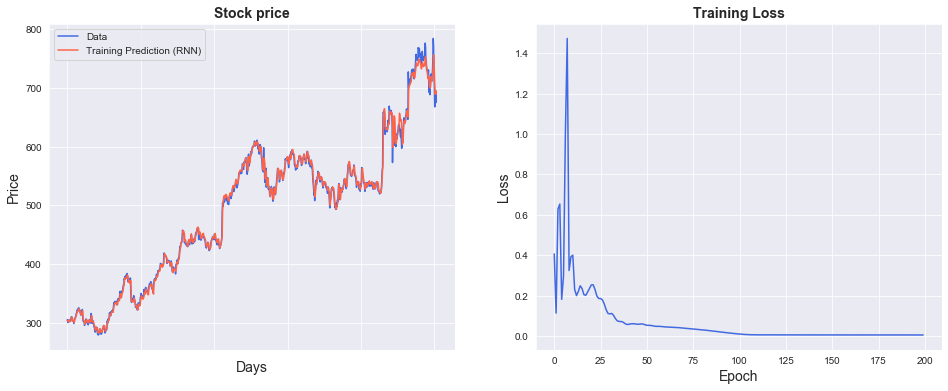

In [49]:
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (RNN)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Price", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [50]:
from sklearn.metrics import mean_squared_error

# make predictions
y_val_pred_rnn = model(x_val)

# invert predictions
y_train_pred_rnn = scaler.inverse_transform(y_train_pred_rnn.detach().numpy())
y_train_rnn = scaler.inverse_transform(y_train_rnn.detach().numpy())

y_val_pred_rnn = scaler.inverse_transform(y_val_pred_rnn.detach().numpy())
y_val_rnn = scaler.inverse_transform(y_val_rnn.detach().numpy())

rnn_train_error_list = [] 
for i in range(5):
    train_error_rnn = (np.square(y_train_rnn[:,i]-y_train_pred_rnn[:,i])).mean()
    train_error_rnn = np.sqrt(train_error_rnn)
    rnn_train_error_list.append(train_error_rnn)


rnn_val_error_list = []    
for i in range(5):
    val_error_rnn = (np.square(y_val_rnn[:,i]-y_val_pred_rnn[:,i])).mean()
    val_error_rnn = np.sqrt(val_error_rnn)
    rnn_val_error_list.append(val_error_rnn)


In [51]:
# make predictions
y_test_pred_rnn = model(x_test)

# invert predictions
y_test_pred_rnn = y_test_pred_rnn.detach().numpy()
y_test_pred_rnn = scaler.inverse_transform(y_test_pred_rnn)

y_test_rnn = y_test_rnn.detach().numpy()
y_test_rnn = scaler.inverse_transform(y_test_rnn)

rnn_test_error_list = []
for i in range(5):
    test_error_rnn = (np.square(y_test_rnn[:,i]-y_test_pred_rnn[:,i])).mean()
    test_error_rnn = np.sqrt(test_error_rnn)
    rnn_test_error_list.append(test_error_rnn)
    
print(rnn_test_error_list)


[36.102825, 34.79655, 42.58484, 27.93179, 795266.56]


In [52]:
Error_test_pct_list_rnn = []

for i in range(5):
    Error_test_pct_rnn = abs(y_test_rnn[:,i] - y_test_pred_rnn[:,i])
    Error_test_pct_rnn = np.mean(Error_test_pct_rnn)
    Error_test_pct_rnn = Error_test_pct_rnn/(y_test_pred_rnn[:,i].mean())
    Error_test_pct_list_rnn.append(Error_test_pct_rnn)

print('Vanilla RNN test - (MAPE):', Error_test_pct_list_rnn)     

Vanilla RNN test - (MAPE): [0.045533907, 0.04335966, 0.054942176, 0.033874735, 0.3592274]


### Model Comparison

#### Train error comparison

In [53]:
gru_train_error_list = [round(num, 3) for num in gru_train_error_list]
gru_train_error_list = pd.DataFrame(gru_train_error_list, columns=['gru'])

lstm_train_error_list = [round(num, 3) for num in lstm_train_error_list]
lstm_train_error_list = pd.DataFrame(lstm_train_error_list, columns=['lstm'])

rnn_train_error_list = [round(num, 3) for num in rnn_train_error_list]
rnn_train_error_list = pd.DataFrame(rnn_train_error_list, columns=['rnn'])

train_error = pd.concat([gru_train_error_list, lstm_train_error_list, rnn_train_error_list], axis=1)
train_error.rename({0: 'open', 1: 'high', 2:'low', 3:'close', 4:'volume'}, axis='index')

,gru,lstm,rnn
open,6.522,7.866,8.657000e+00
high,7.424,8.682,9.522000e+00
low,7.612,8.712,9.583000e+00
close,20.708,23.334,2.413100e+01
volume,1547613.500,1680218.863,1.805238e+06


(0, 50)

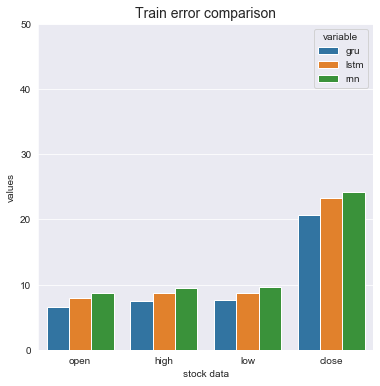

In [54]:
train_error = train_error.iloc[:4,:]
train_error.index  = ["open", "high", "low", 'close']
df_plot = train_error.reset_index().rename({'index': 'stock data'}, axis=1)
df_plot = df_plot.melt(id_vars='stock data')

fig,ax = plt.subplots(figsize=(6,6))
sns.barplot('stock data', 'value', hue='variable', data=df_plot, ax=ax)
plt.title('Train error comparison', fontsize= 14)
plt.xlabel('stock data')
plt.ylabel('values')
plt.ylim(0,50)

#### Validation error comparison

In [55]:
lstm_val_error_list = [round(num, 3) for num in lstm_val_error_list]
lstm_val_error_list = pd.DataFrame(lstm_val_error_list, columns=['lstm'])

gru_val_error_list = [round(num, 3) for num in gru_val_error_list]
gru_val_error_list = pd.DataFrame(gru_val_error_list, columns=['gru'])

rnn_val_error_list = [round(num, 3) for num in rnn_val_error_list]
rnn_val_error_list = pd.DataFrame(rnn_val_error_list, columns=['rnn'])

val_error = pd.concat([gru_val_error_list, lstm_val_error_list, rnn_val_error_list], axis=1)
val_error.rename({0: 'open', 1: 'high', 2:'low', 3:'close', 4:'volume'}, axis='index')


,gru,lstm,rnn
open,6.378,7.852,19.443001
high,6.877,7.542,19.010000
low,9.169,12.078,24.898001
close,8.396,11.207,16.579000
volume,803714.000,1002798.794,945420.937500


(0, 50)

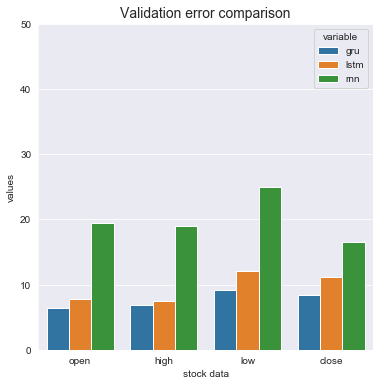

In [56]:
val_error = val_error.iloc[:4,:]
val_error.index  = ["open", "high", "low", 'close']
df_plot = val_error.reset_index().rename({'index': 'stock data'}, axis=1)
df_plot = df_plot.melt(id_vars='stock data')

fig,ax = plt.subplots(figsize=(6,6))
sns.barplot('stock data', 'value', hue='variable', data=df_plot, ax=ax)
plt.title('Validation error comparison', fontsize= 14)
plt.xlabel('stock data')
plt.ylabel('values')
plt.ylim(0,50)

#### Test error comparison


In [57]:
lstm_test_error_list = [round(num, 3) for num in lstm_test_error_list]
lstm_test_error_list = pd.DataFrame(lstm_test_error_list, columns=['lstm'])

gru_test_error_list = [round(num, 3) for num in gru_test_error_list]
gru_test_error_list = pd.DataFrame(gru_test_error_list, columns=['gru'])

rnn_test_error_list = [round(num, 3) for num in rnn_test_error_list]
rnn_test_error_list = pd.DataFrame(rnn_test_error_list, columns=['rnn'])

test_error = pd.concat([gru_test_error_list, lstm_test_error_list, rnn_test_error_list], axis=1)
test_error.rename({0: 'open', 1: 'high', 2:'low', 3:'close', 4:'volume'}, axis='index')

,gru,lstm,rnn
open,6.9180,11.466,36.103001
high,6.9230,9.954,34.797001
low,11.1580,18.450,42.584999
close,9.7370,17.747,27.931999
volume,843870.8125,972189.922,795266.562500


(0, 50)

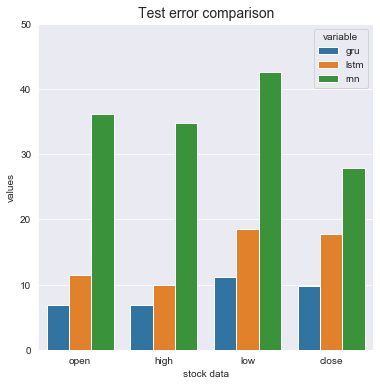

In [58]:
test_error = test_error.iloc[:4,:]
test_error.index  = ["open", "high", "low", 'close']
df_plot = test_error.reset_index().rename({'index': 'stock data'}, axis=1)
df_plot = df_plot.melt(id_vars='stock data')

fig,ax = plt.subplots(figsize=(6,6))
sns.barplot('stock data', 'value', hue='variable', data=df_plot, ax=ax)
plt.title('Test error comparison', fontsize= 14)
plt.xlabel('stock data')
plt.ylabel('values')
plt.ylim(0,50)

#### Comparision of predicted vs actual value

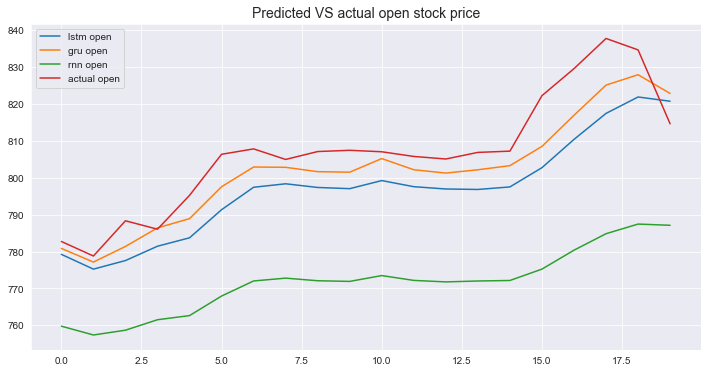

In [59]:
plt.figure(figsize=(12,6))
plt.plot(y_test_pred_lstm[:,0], label='lstm open');
plt.plot(y_test_pred_gru[:,0], label='gru open');
plt.plot(y_test_pred_rnn[:,0], label='rnn open');
plt.plot(y_test_lstm[:,0], label='actual open');
plt.title('Predicted VS actual open stock price', fontsize=14)
plt.legend()

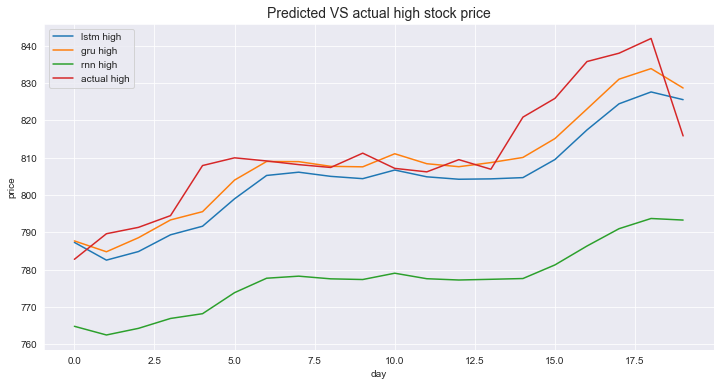

In [60]:
plt.figure(figsize=(12,6))
plt.plot(y_test_pred_lstm[:,1], label='lstm high');
plt.plot(y_test_pred_gru[:,1], label='gru high');
plt.plot(y_test_pred_rnn[:,1], label='rnn high');
plt.plot(y_test_lstm[:,1], label='actual high');
plt.title('Predicted VS actual high stock price', fontsize=14)
plt.xlabel('day')
plt.ylabel('price')
plt.legend()

In [61]:
y_test_pred_lstm.shape

(20, 5)

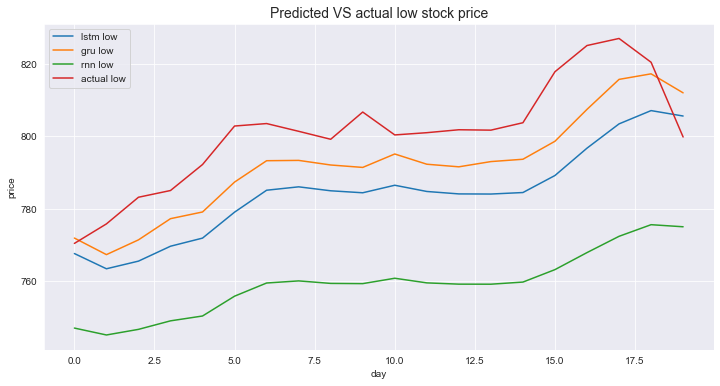

In [62]:
plt.figure(figsize=(12,6))
plt.plot(y_test_pred_lstm[:,2], label='lstm low');
plt.plot(y_test_pred_gru[:,2], label='gru low');
plt.plot(y_test_pred_rnn[:,2], label='rnn low');
plt.plot(y_test_lstm[:,2], label='actual low');
plt.title('Predicted VS actual low stock price', fontsize=14)
plt.xlabel('day')
plt.ylabel('price')
plt.legend()

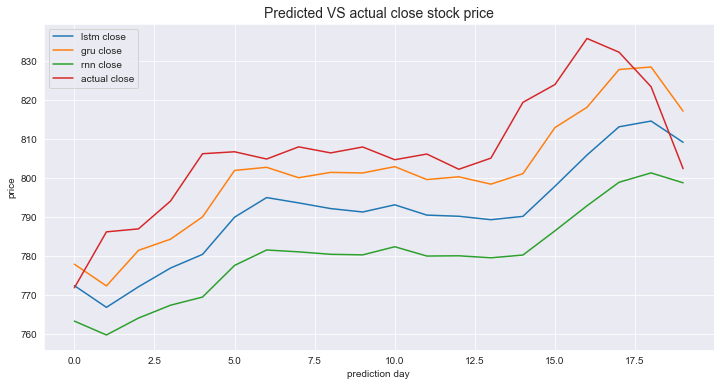

In [63]:
plt.figure(figsize=(12,6))
plt.plot(y_test_pred_lstm[:,3], label='lstm close');
plt.plot(y_test_pred_gru[:,3], label='gru close');
plt.plot(y_test_pred_rnn[:,3], label='rnn close');
plt.plot(y_test_lstm[:,3], label='actual close');
plt.title('Predicted VS actual close stock price', fontsize=14)
plt.xlabel('prediction day')
plt.ylabel('price')
plt.legend()

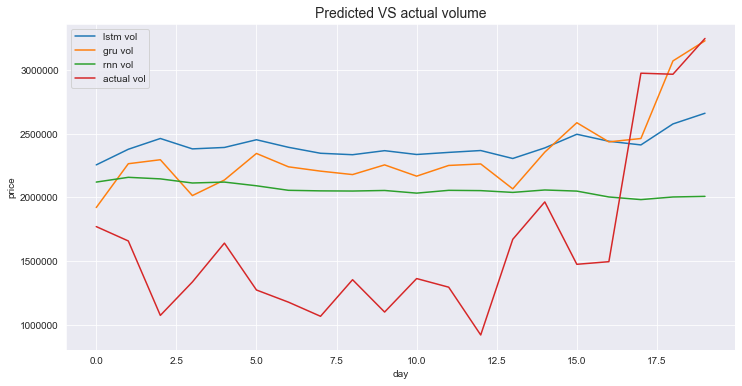

In [64]:
plt.figure(figsize=(12,6))
plt.plot(y_test_pred_lstm[:,4], label='lstm vol');
plt.plot(y_test_pred_gru[:,4], label='gru vol');
plt.plot(y_test_pred_rnn[:,4], label='rnn vol');
plt.plot(y_test_lstm[:,4], label='actual vol');
plt.title('Predicted VS actual volume', fontsize=14)
plt.xlabel('day')
plt.ylabel('price')
plt.legend()